In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import polars as pl
import lightgbm as lgb
import joblib
from lightgbm import LGBMRegressor

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)

polars.config.Config

In [2]:
multi_index = ['date_id', 'time_id', 'symbol_id']
feature_col = [f'feature_{i:02d}' for i in range(79)]
most_na_feat = ['feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04',
                'feature_21', 'feature_26', 'feature_27', 'feature_31']

weight = ['weight']
target = ['responder_6']
interest_col = multi_index + feature_col + weight + target

In [3]:
df = (pl.scan_parquet('data/train.parquet')
      .select(interest_col).drop(most_na_feat)
      .filter(pl.col('date_id') <= 249)
      .sort(['date_id', 'time_id','symbol_id', ])
      .collect())

df.tail()

date_id,time_id,symbol_id,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_28,feature_29,feature_30,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,weight,responder_6
i16,i16,i8,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
249,848,19,-0.540453,0.413043,0.134619,0.50884,4,3,11,0.457439,0.520245,0.171513,-1.036064,-0.815763,-0.78367,-0.707164,1.979522,0.322928,2.004154,0.620742,0.783256,0.651648,0.902313,-0.79834,-0.677254,0.854708,0.926135,0.515709,0.825353,-0.213756,-0.226529,0.114472,-0.031299,-0.426968,0.204152,-0.458674,0.67038,0.278078,0.03934,-0.209089,-0.221864,0.092465,-0.053698,-0.480844,0.074376,0.028695,-0.305078,0.474705,1.736077,-0.028978,0.050152,-0.20482,0.775712,0.223812,-1.146347,-0.425854,-0.297129,-0.23373,-0.355446,2.419973,0.295755,0.182121,-0.08379,0.694096,0.647929,0.428127,0.175497,0.246604,-0.248399,-0.231207,0.163621,0.132324,5.334031,-0.235857
249,848,30,-0.505748,0.774338,0.198202,1.153822,81,2,534,0.336658,1.025678,1.199736,-0.052331,0.082207,0.042919,3.68191,-0.969808,-0.306558,-1.009684,-0.904774,-0.081871,-0.245165,0.120115,-0.153194,-0.148646,0.133923,0.845639,-0.007032,0.476366,1.505071,0.469162,0.418045,-1.097294,-0.225565,-0.708785,0.283482,0.528443,0.931038,-0.632176,-0.303106,0.270279,-0.017666,0.385908,-0.097668,0.682118,0.501132,-0.362924,0.188913,-0.528249,-1.512408,-0.204883,-0.169994,-0.109933,0.027842,-1.146347,0.210808,-0.017585,-0.009932,1.223792,0.204996,0.374888,0.685378,0.73366,0.408175,1.130151,1.793579,0.702954,0.595174,0.808082,0.823547,0.327106,0.311896,0.654443,-0.716045
249,848,33,-0.533114,0.604238,0.135995,0.958525,11,7,76,0.430932,0.057042,0.215041,-0.243066,-0.367085,-0.234533,-0.041571,1.840037,1.626936,-0.678187,-0.254641,0.75815,0.289593,0.00431,-0.144771,-0.237504,0.711029,0.19814,0.558642,0.19289,-1.656222,-0.006727,0.049094,-0.865293,-0.010998,-0.359282,-1.179446,-0.934574,-1.053784,0.449245,-0.038745,-0.839017,-0.228076,-0.644632,-0.429944,-0.114341,0.143842,-0.219006,-0.05191,0.387699,0.880018,0.330224,-0.428363,0.27906,0.103157,-1.146347,0.046061,-0.139452,-0.121744,-0.569545,1.593127,0.363155,0.053957,0.037811,0.403244,0.150093,0.334373,-0.102945,-0.061946,-0.169453,-0.307933,-0.191917,-0.257567,1.30112,-0.073751
249,848,34,-0.573373,0.742891,0.145958,0.837401,42,5,150,1.96712,1.508694,2.136301,-0.383647,-0.388498,-0.438964,0.844231,-0.329563,0.3489,-0.874623,-1.008039,-0.773849,-1.222574,1.676876,-0.632209,-0.457651,0.110265,-1.513513,0.945506,1.108474,-1.670439,0.831203,0.968621,-2.309436,-2.15593,-2.609946,-1.600304,-1.807091,-2.543915,-0.474823,-0.954912,-1.194855,-0.020261,-1.223277,-0.073204,0.453142,0.71084,-1.388866,1.167403,0.366767,0.410952,-0.96041,-0.379291,1.000836,-0.064538,-1.146347,1.988884,2.195381,2.285891,1.211138,0.138659,2.567461,1.578904,1.084654,2.287818,1.639262,1.257084,1.071653,1.071908,-1.615903,-0.960117,0.230698,0.070209,0.956719,-0.261047
249,848,38,-0.645481,0.388607,0.150381,1.036132,50,1,522,0.994645,1.795689,0.883299,-0.459925,-0.406049,-0.438502,-0.084736,1.223957,1.175076,-0.210773,-0.308979,0.129744,-0.032989,1.444086,-0.669622,-0.598616,0.523043,-0.96

In [4]:
# X = df.drop(['date_id', 'time_id', target]).to_pandas()
X = X = df.drop(multi_index+weight+target).to_pandas()
y = df[target].to_pandas()
sample_weight = df[weight].to_pandas().values.flatten()

In [5]:
print(X.columns)

Index(['feature_05', 'feature_06', 'feature_07', 'feature_08', 'feature_09',
       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19',
       'feature_20', 'feature_22', 'feature_23', 'feature_24', 'feature_25',
       'feature_28', 'feature_29', 'feature_30', 'feature_32', 'feature_33',
       'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38',
       'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43',
       'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48',
       'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53',
       'feature_54', 'feature_55', 'feature_56', 'feature_57', 'feature_58',
       'feature_59', 'feature_60', 'feature_61', 'feature_62', 'feature_63',
       'feature_64', 'feature_65', 'feature_66', 'feature_67', 'feature_68',
       'feature_69', 'feature_70', 'feature_71', 'feature_72', 'feature_73',

In [6]:
parm = {'n_estimators':1000, 'max_depth':6, 'num_leaves':64, 'learning_rate':0.05,
        'colsample_bytree':0.5, 'importance_type':'gain', 'boosting_type':'dart' ,'random_state':0, 'n_jobs':-1}
model = LGBMRegressor(**parm)

In [7]:
model.fit(X, y, sample_weight=sample_weight)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.299781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17113
[LightGBM] [Info] Number of data points in the train set: 3232143, number of used features: 70
[LightGBM] [Info] Start training from score 0.000233
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

LGBMRegressor(boosting_type='dart', colsample_bytree=0.5,
              importance_type='gain', learning_rate=0.05, max_depth=6,
              n_estimators=1000, n_jobs=-1, num_leaves=64, random_state=0)

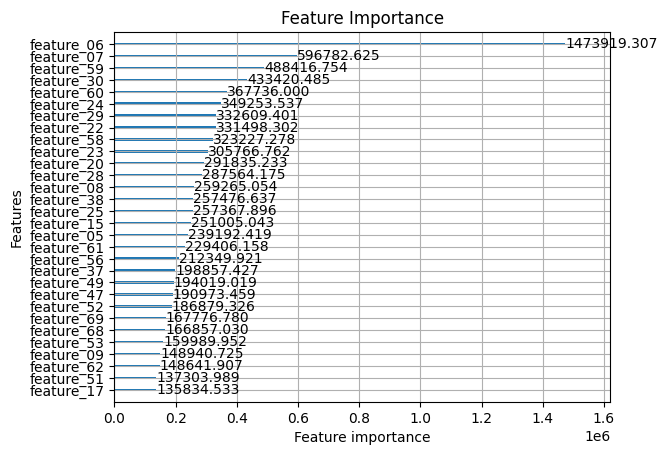

In [8]:
lgb.plot_importance(model, max_num_features=30, importance_type='gain')  # 或 'gain'
plt.title("Feature Importance")
plt.show()

In [9]:
data = {
    'model' : model, 
    'feature' : X.columns.tolist(),
    'parmaters' : parm
    }

joblib.dump(data, './model/lgbm3-1_d6_n1000.pkl')

['./model/lgbm3-1_d6_n1000.pkl']